In [1]:
import sys
!{sys.executable} -m pip install webcolors
!{sys.executable} -m pip install plotly==5.7.0
!{sys.executable} -m pip install --upgrade nbformat
!{sys.executable} -m pip install tune-sklearn ray[tune]
!{sys.executable} -m pip install packaging
!{sys.executable} -m pip install -U kaleido

Import necessary packages
---

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import pdb, itertools, os, time, sys, re, random, pickle, shutil
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from utils import *
from config import current_config as config
from models.performAnalysis import performAnalysis

plt.rcParams["font.family"] = "DejaVu Sans"

Check the validity of the paremeters
---

In [3]:
supported_classif_methods = ['pc-lda', 'rf', 'pc-rf', 'lda-rf', 'svm','pc-svm','lda-svm']
supported_ML_methods = supported_classif_methods + ['pca']


ML_method_list = config.ML_method_list
# Get rid of unsupported ML methods
for curr_ML_method in ML_method_list:
    if not (curr_ML_method in supported_ML_methods):
        ML_method_list.remove(curr_ML_method)
        print(curr_ML_method,'is currently unsupported')
print('The ML methods that will be used include', ML_method_list)

if not (config.data_split_method in ['intra','inter','by-folders']):
    print('Invalid data_split_method.')
    sys.exit(1)

The ML methods that will be used include ['pca', 'pc-lda', 'lda-rf', 'lda-svm']


Prepare some information
---

In [4]:
# Generate a list of random seeds to perform experiments
if config.data_split_method == 'intra':
    random_seed_list = np.random.randint(config.num_repetitions_intra*10, size=config.num_repetitions_intra)

# Define the base directory
cwd = os.getcwd()
if config.data_split_method in ['intra','inter']:
    data_base_dir = os.path.join(cwd,'data_auto_split')
else:
    data_base_dir = os.path.join(cwd,'data_manual_split')
        
exp_base_dir = os.path.join(data_base_dir,config.experiment_name)

# Define a list of experiments
if os.path.exists(exp_base_dir):
    experiment_name_list = [exp_base_dir]
else:
    print('No such experiment. These are all existing experiments: ')
    experiment_name_list = create_dir_list_no_hidden_dir(data_base_dir)
    for curr_exp_name in experiment_name_list:
        print(curr_exp_name)
    print('Input [c] if you want to run these experiments')
    pdb.set_trace()

num_exps = len(experiment_name_list)
num_ML_methods = len(ML_method_list)

# Count the number of classification methods. Intentionally didn't implement the set approach 
# to make sure of the consistency between the orders of the lists.
ML_classif_method_list = []
for curr_ML_method in ML_method_list:
    if curr_ML_method in supported_classif_methods:
        ML_classif_method_list.append(curr_ML_method)
num_classif_methods = len(ML_classif_method_list)

# Generate color list for classification bar plots
color_list_for_bar_plots = []
for idx_ML_method in range(num_classif_methods):
    color_list_for_bar_plots.append(rgb_to_hex((random.randint(0,255), random.randint(0,255), random.randint(0,255))))

No such experiment. These are all existing experiments: 
/home/jupyter-ichatnun/projects/SERS_Analysis/data_auto_split/EX1-raw
Input [c] if you want to run these experiments
--Return--
> <ipython-input-4-96d0b79f7a56>(23)<module>()->None
-> pdb.set_trace()


(Pdb)  c


Run the experiment(s)
---

***********************************************************
Begin experiment  1 / 1 : EX1-raw
***********************************************************
Classes =  ['Buffer', 'HEK']
and their corresponding colors:  ['#0000ff', '#008000']
Use the raman shifts specified in /home/jupyter-ichatnun/projects/SERS_Analysis/data_auto_split/EX1-raw/raman_shifts.csv
------ Begin: Extract all the spectra ------
/home/jupyter-ichatnun/projects/SERS_Analysis/data_auto_split/EX1-raw/Buffer/Buffer_onSERS_Pos1_spectra.pkl already exists, so just load it.
Done processing 1/6: /home/jupyter-ichatnun/projects/SERS_Analysis/data_auto_split/EX1-raw/Buffer/Buffer_onSERS_Pos1.txt

/home/jupyter-ichatnun/projects/SERS_Analysis/data_auto_split/EX1-raw/Buffer/Buffer_onSERS_Pos2_spectra.pkl already exists, so just load it.
Done processing 2/6: /home/jupyter-ichatnun/projects/SERS_Analysis/data_auto_split/EX1-raw/Buffer/Buffer_onSERS_Pos2.txt

/home/jupyter-ichatnun/projects/SERS_Analysis/data_auto_split/EX1-raw

<Figure size 432x288 with 0 Axes>

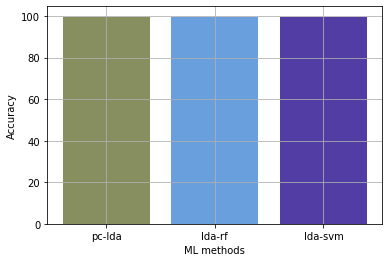

Done
***********************************************************


In [5]:
for idx_exp, curr_exp_path in enumerate(experiment_name_list):
    
    # Prepare a directory for saving the results
    curr_exp_name = os.path.basename(curr_exp_path)
    results_path = os.path.join(cwd,config.results_folder_name, curr_exp_name, config.data_split_method)

    if config.REMOVE_BASELINE:
        results_path += '_baseline_removed'

    if os.path.exists(results_path):
        shutil.rmtree(results_path)
    
    os.makedirs(results_path)
    
    # Copy the config file
    shutil.copy2('./config/current_config.py', os.path.join(results_path))
    
        
    print('***********************************************************')
    print('Begin experiment ', idx_exp+1, '/', num_exps,':',curr_exp_name)
    print('***********************************************************')
    
    # Extract classes
    if config.data_split_method in ['intra','inter']:
        class_list = get_class_names(curr_exp_path)
        
    elif config.data_split_method in ['by-folders']:
        class_list_train = get_class_names(os.path.join(curr_exp_path,'train'))
        class_list_test = get_class_names(os.path.join(curr_exp_path,'test'))
        
        if set(class_list_train) == set(class_list_test):
            class_list = class_list_test
        else:
            print('Training and test class lists are not the same.')
            sys.exit(1)
        
    print('Classes = ', class_list)
            
    # Generate a color list for each class
    colors_list,color_dict = createColorList(config.color_dict,class_list)
    print('and their corresponding colors: ', colors_list)
    
    ########## Load data ##########
    
    # If the user has provided the raman shift file, load it.
    ramanshifts_filepath = os.path.join(curr_exp_path,'raman_shifts.csv')
    if os.path.exists(ramanshifts_filepath):
        df = pd.read_csv(ramanshifts_filepath)
        desired_ramanshifts = df['shifts'].values
        del df
        print('Use the raman shifts specified in', ramanshifts_filepath)
        shutil.copy2(ramanshifts_filepath, os.path.join(results_path))

    else:
        # Determine common wavenumbers
        desired_ramanshifts = getCommonWavenumbers(curr_exp_path, class_list)
            
        df_out = pd.DataFrame(desired_ramanshifts,columns=['shifts'])
        df_out.to_csv(os.path.join(results_path,'raman_shifts.csv'),index=False,index_label='shifts')
        del df_out


    # Load the data from the 'intra' and 'inter' cases
    if config.data_split_method in ['intra','inter']:
        
        # Extract the spectra and interpolate the wavenumbers to align with 'common_wavenumbers'
        spectra, _ = extractAllSpectra(curr_exp_path, 
                                       class_list,
                                       desired_wavenumbers=desired_ramanshifts,
                                       REMOVE_BASELINE=config.REMOVE_BASELINE,
                                       OVERWRITE_PRELOADED_DATA=config.OVERWRITE_PRELOADED_DATA)
        del desired_ramanshifts

        ########## Define the data-splitting parameters ##########
        if config.data_split_method in ['intra']:
            num_repetitions = config.num_repetitions_intra
            fraction_test =  config.fraction_test_intra

        elif config.data_split_method in ['inter']:

            # Figure out the minimum number of files in a class for the current experiment
            min_num_files_per_class = 100000
            for curr_class in class_list:
                curr_num_files_per_class = len(glob.glob(os.path.join(curr_exp_path,curr_class,'*.txt')))
                if min_num_files_per_class > curr_num_files_per_class:
                    min_num_files_per_class = curr_num_files_per_class

            num_repetitions = min_num_files_per_class
            fraction_test = 1.0/min_num_files_per_class
            
    elif config.data_split_method in ['by-folders']:
        num_repetitions = 1
        spectra_training, _ = extractAllSpectra(os.path.join(curr_exp_path,'train'), 
                                                class_list,
                                                desired_wavenumbers=desired_ramanshifts,
                                                REMOVE_BASELINE=config.REMOVE_BASELINE,
                                                OVERWRITE_PRELOADED_DATA=config.OVERWRITE_PRELOADED_DATA)
        spectra_test, _ = extractAllSpectra(os.path.join(curr_exp_path,'test'), 
                                            class_list,
                                            desired_wavenumbers=desired_ramanshifts,
                                            REMOVE_BASELINE=config.REMOVE_BASELINE,
                                            OVERWRITE_PRELOADED_DATA=config.OVERWRITE_PRELOADED_DATA)
        
    
    acc_all_reps_all_methods = np.zeros((num_repetitions,num_classif_methods))
    
    for idx_rep in range(num_repetitions):
        
        print('Rep ', idx_rep+1, '/', num_repetitions,'\n')            

        ########## Perform training/test data splitting ##########
        if config.data_split_method in ['intra','inter']:
            params_data_splitting = {'data_split_method':config.data_split_method,
                                     'spectra':spectra,
                                     'class_list':class_list,
                                     'fraction_test':fraction_test}

            if config.data_split_method in ['intra']:
                params_data_splitting.update({'random_seed': random_seed_list[idx_rep]})
                spectra_training, spectra_test, labels_training, labels_test = trainTestSplitting(**params_data_splitting)

            elif config.data_split_method in ['inter']:
                params_data_splitting.update({'idx_target_file_for_inter_test': idx_rep})
                spectra_training, spectra_test, labels_training, labels_test = trainTestSplitting(**params_data_splitting)
        
        elif config.data_split_method in ['by-folders']:
            spectra_training, labels_training = loadSpectraAndLabels(spectra_training, class_list)
            spectra_test, labels_test = loadSpectraAndLabels(spectra_test, class_list)
            
    
        print('# of training spectra = ', spectra_training.shape[0])
        print('# of test spectra = ', spectra_test.shape[0])

        ########## Apply each ML method ##########
        count_classif_method = 0
        params = {'class_list':class_list,
                 'x_train':spectra_training,
                 'y_train':labels_training,
                 'x_test':spectra_test,
                 'y_test':labels_test,
                 'color_dict':color_dict}
        
        for idx_ML_method, curr_ML_method in enumerate(ML_method_list):
            
            print('\n\tML method ', idx_ML_method+1, '/',num_ML_methods,':',curr_ML_method)
            
            # Prepare the folder to save the results
            temp_base_results_path = os.path.join(results_path,
                       'rep'+str(idx_rep+1),
                       curr_ML_method)
            
            if not os.path.exists(temp_base_results_path):
                os.makedirs(temp_base_results_path)
                
            params.update({'results_path':temp_base_results_path})
                    
            
            # Apply the current ML model
            if curr_ML_method in supported_classif_methods:
                
                acc = performAnalysis(method_name=curr_ML_method, params=params)
                
                # Update the classification accuracy matrix
                acc_all_reps_all_methods[idx_rep,count_classif_method] = acc
                count_classif_method += 1
                
            else: 
                performAnalysis(method_name=curr_ML_method, params=params)
            
    # Save the overall accuracies
    mean_acc = np.mean(acc_all_reps_all_methods,axis=0)
    std_acc = np.std(acc_all_reps_all_methods,axis=0)
    stats = np.concatenate((acc_all_reps_all_methods,np.expand_dims(mean_acc,axis=0)),axis=0)
    stats = np.concatenate((stats,np.expand_dims(std_acc,axis=0)),axis=0)

    df = pd.DataFrame(stats, columns = ML_classif_method_list)

    df_index_temp = []
    for idx_rep in range(num_repetitions):
        df_index_temp.append('Rep '+ str(idx_rep+1))
    df_index_temp.append('Mean')
    df_index_temp.append('Std')
    df.index = df_index_temp

    df.to_csv(os.path.join(results_path,'accuracy_test_reps.csv'))

    # Create and save the classification accuracy bar plot
    plt.figure()
    plt.bar(ML_classif_method_list, mean_acc, yerr=std_acc, color=color_list_for_bar_plots)
    plt.xlabel('ML methods')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.savefig(fname=os.path.join(results_path, 'acc_test_bar_plot.jpg'),dpi=300, bbox_inches='tight')
    plt.show()
    
print('Done')
print('***********************************************************')